<font size = '12'> **Calculating probability density function** </font>  
  
This notebook shows how to calculate unweighted probability density functions using three different methods.

# Loading relevant libraries

In [1]:
import ZonalStatsFunctions as zsf
import xarray as xr
import numpy as np
import os
from dask.distributed import Client
import scipy.stats as ss
from glob import glob
from sklearn.neighbors import KernelDensity

#Useful for plotting figures, including maps
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
client = Client(n_workers = 12)

# Defining seasons and regions

In [2]:
#Defining sea ice seasons
SI_seasons = ['advance', 'retreat', 'duration']

#Defining sector names in order
sectorNames = ['East Pacific', 'Atlantic', 'Central Indian', 'East Indian', 'West Pacific']

# Loading clipped model data

In [3]:
#Clipped data location
out_file = sorted(glob(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/MEASOregions/*.nc'))

#Creating an empty dictionary to load data
clipped_SIS = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in out_file if sec in file]
    #Loop through each season within each sector
    for sea in SI_seasons:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).sel(yt_ocean = slice(-80, -50))
        if sec != 'West Pacific':
            clipped_SIS[f'{sec}_{sea}'] = clipped_SIS[f'{sec}_{sea}'].dropna('xt_ocean', how = 'all')

# Loading clipped observational data
In case data has already been clipped.

In [103]:
#Getting a list of nc files inside the folder containing the clipped data
in_files = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/MEASOregions/*.nc'))

#Creating an empty dictionary to load data
clipped_SIS_obs = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in in_files if sec in file]
    #Loop through each season within each sector
    for sea in SI_seasons:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS_obs[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).sel(yt_ocean = slice(-80, -50))
        if sec != 'West Pacific':
            clipped_SIS_obs[f'{sec}_{sea}'] = clipped_SIS_obs[f'{sec}_{sea}'].dropna('xt_ocean', how = 'all')

# Plot PDFs observations and model outputs per sector
Comparisons will use data for the period between 1979/80 and 2017/18 because these years are available in observations and model outputs.

## Using matplotlib hist function

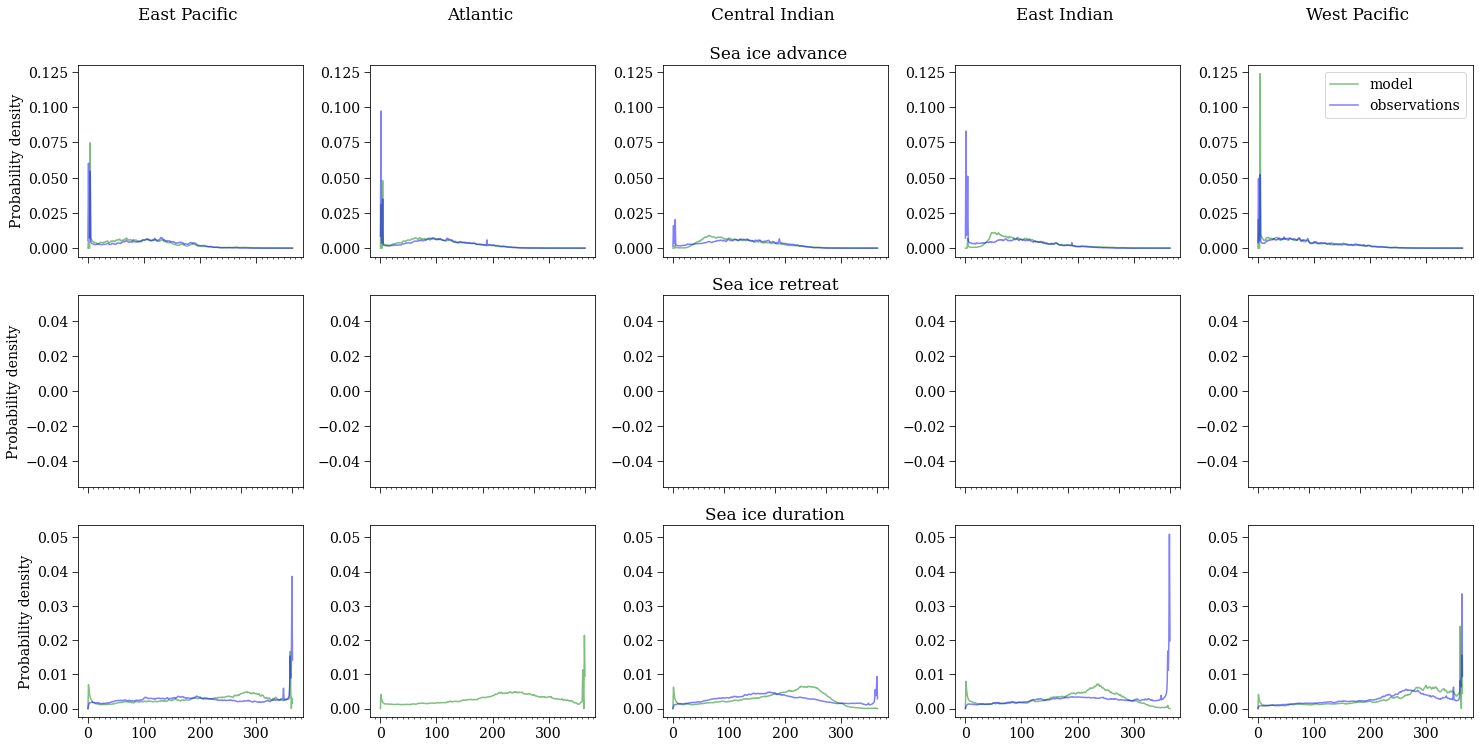

In [123]:
#Initialising figure
fig = plt.figure(figsize = (25, 12))

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create a grid inside the figure with seasons defining the number of rows and one column
gs = gridspec.GridSpec(nrows = len(SI_seasons), ncols = 1)

for i in range(len(SI_seasons)):
    #Create a list to hold axes information for every row. Each row will contain the 
    #same amount of plots as there are sectors.
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    #Create a subgrid for each row in the main grid. Each row will contain 
    #the same amount of plots as there are sectors. 
    #Decrease blank space between plots
    si_season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames), 
                                                 subplot_spec = gs[i], wspace = 0.3)
    
    #Plotting figures in each grid cell (row wise)
    for j in range(len(sectorNames)):
        #Initilise figures in each grid cell. Ensure x and y axes are shared 
        #across the entire row
        ax = plt.Subplot(fig, si_season[0, j], sharex = axes[0, 0], 
                         sharey = axes[0, 0])
        fig.add_subplot(ax)
        #Adding local axis value to empty axes list 
        axes[0, j] = ax
        
        #Calculating yearly means per sector and per season, and plotting them
        clipped_SIS[sectorNames[j]][SI_seasons[i]].sel(time = slice('1979', '2017')).\
        plot.hist(bins = 'auto', color = 'green', alpha = 0.5, density = True, 
                  label = 'model', ax = ax)
        clipped_SIS_obs[sectorNames[j]][SI_seasons[i]].sel(time = slice('1979', '2017')).\
        plot.hist(bins = 'auto', color = 'blue', density = True, label = 'observations', 
                  histtype = 'step', linewidth = 1, ax = ax)
        ax.set_title('')
        ax.set_ylabel('')
        ax.set_xlabel('')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included
        #between each major tick pair 
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 10))
        if j == 4 and i == 0:
            ax.legend()
        #Specifying how figure titles should appear in each grid cell
        if SI_seasons[i] == SI_seasons[0] and sectorNames[j] == sectorNames[2]:
            ax.set_title(f'{sectorNames[j]} \n \n Sea ice {SI_seasons[i]}')
        elif SI_seasons[i] == SI_seasons[0] and sectorNames[j] != sectorNames[2]: 
            ax.set_title(f'{sectorNames[j]} \n \n')
        elif SI_seasons[i] != SI_seasons[0] and sectorNames[j] == sectorNames[2]:
            ax.set_title(f'Sea ice {SI_seasons[i]}')
        else:
            ax.set_title('')
        #Show x tick labels only in the last row
        if SI_seasons[i] != SI_seasons[-1]:
            ax.set_xticklabels([])
        #Include the y axis title and labels only for the first column
        if sectorNames[j] == sectorNames[0]:
            ax.set_ylabel('Probability density')
        #Remove all y labels and titles in any other grid cell
        else:
            ax.set_ylabel('')
#             ax.yaxis.set_tick_params(labelleft = False) 

#Saving climatology
out_file = r'/g/data/v45/la6889/Figures/PDFs/SIS'
#Ensuring file exists
os.makedirs(out_file, exist_ok = True)       
            
#Saving final figure
plt.savefig(os.path.join(out_file, 'PDFs_MEASOsectors.png'), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

## Using xarray histogram function

In [15]:
def plot_PDF(obs, mod, **kwargs):
    if 'bins' in kwargs.keys():
        bins = kwargs.get('bins')
    else:
        bins = 'auto'
    
    #Initialising figure
    fig = plt.figure(figsize = (15, 5))

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Create a grid inside the figure with seasons defining the number of rows and one column
    gs = gridspec.GridSpec(ncols = len(SI_seasons), nrows = 1)
    gs.update(wspace = 0.3)
    
    for i in range(len(SI_seasons)):
        ax = fig.add_subplot(gs[i])
        #Plotting histogram for SIS from models
        mod[SI_seasons[i]].sel(time = slice('1979', '2017')).\
        plot.hist(bins = bins, color = 'green', alpha = 0.5, density = True, 
                  label = 'model', ax = ax)
        #Plotting histogram for SIS from observations
        obs[SI_seasons[i]].sel(time = slice('1979', '2017')).\
        plot.hist(bins = bins, color = 'blue', density = True, 
                  label = 'observations', histtype = 'step', linewidth = 1, ax = ax)
        ax.set_title(f'{SI_seasons[i].title()}')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included
        #between each major tick pair 
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 10))
        if i < 2:
            ax.set_xlabel('Number of days from February 14')
        else:
            ax.set_xlabel('Total number of days')
            ax.legend(loc = 'upper center')
    
    reg = str(obs.region.values)
    fig.suptitle(f'Probability density for sea ice season metrics in the {reg} sector (1979-2017)',
                y = 1.01)

    #Saving figure
    if 'out_folder' in kwargs.keys():
        #Ensuring folder exists
        os.makedirs(kwargs.get('out_folder'), exist_ok = True)
        plt.savefig(os.path.join(kwargs.get('out_folder'), f'PDFs_{reg}_1979-2017.png'), 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

[None, None, None, None, None]

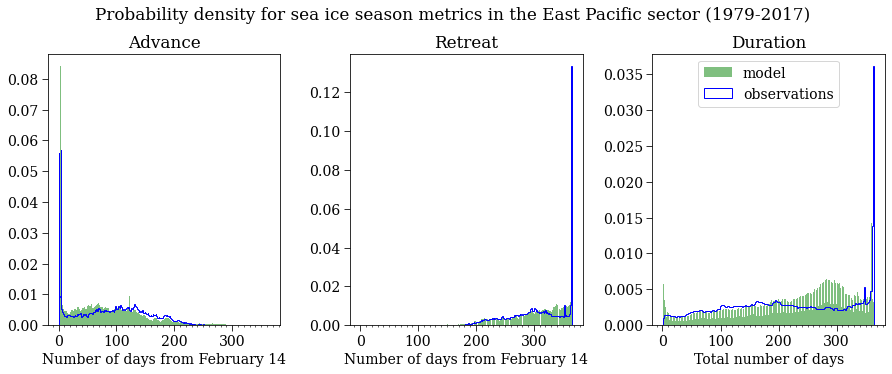

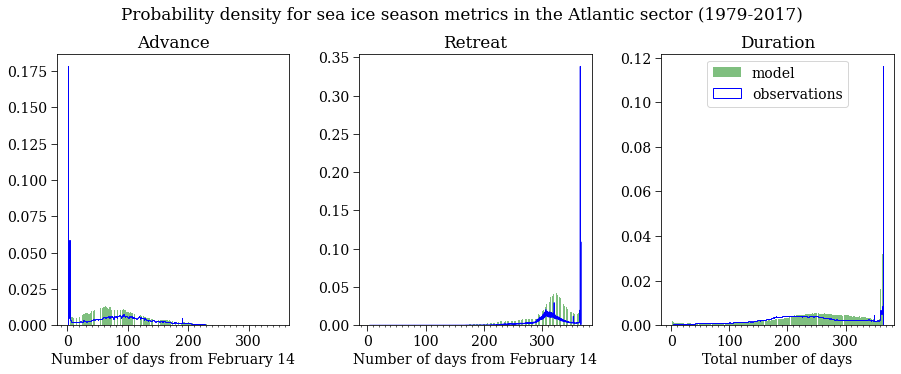

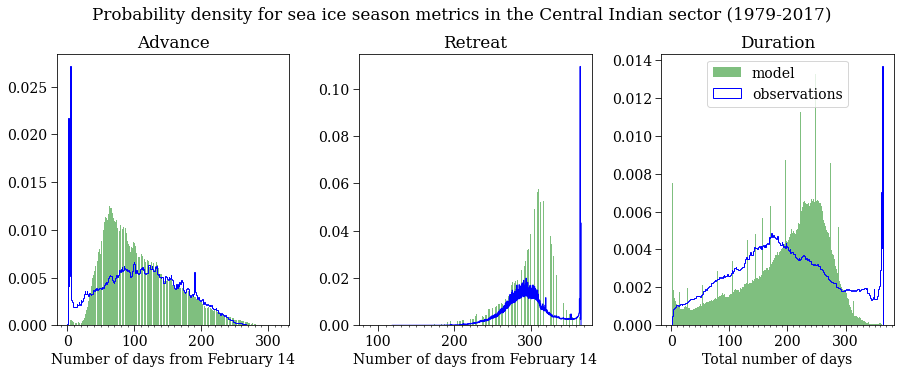

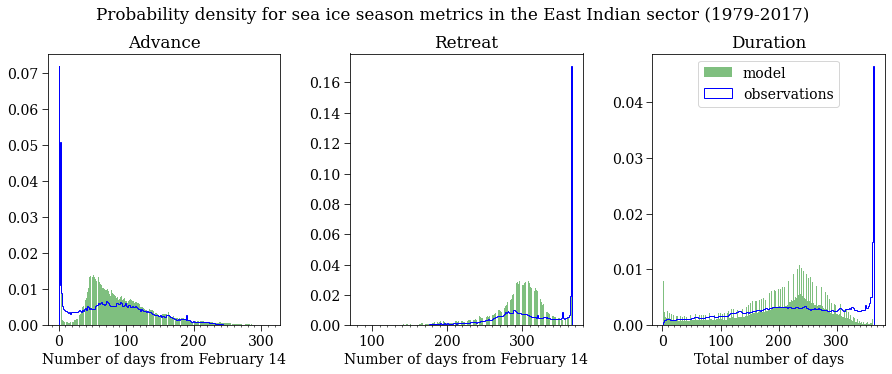

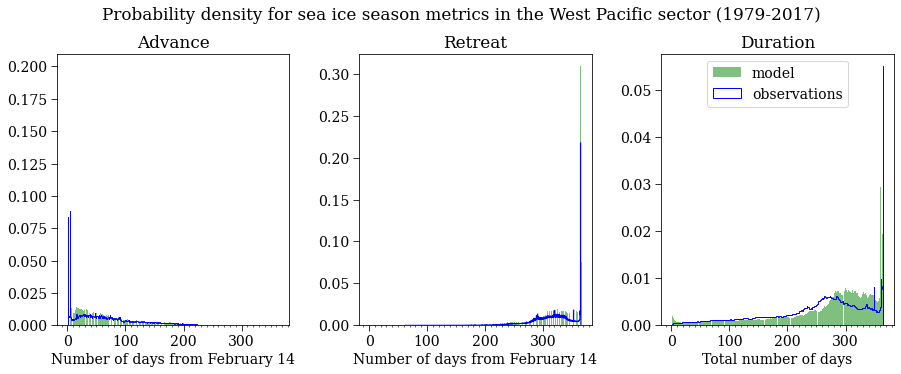

In [17]:
#Folder where figures will be saved
out_folder = r'/g/data/v45/la6889/Figures/PDFs/SIS/'
#Apply plotting function
[plot_PDF(clipped_SIS_obs[sec], clipped_SIS[sec], bins = np.arange(0, 367),
          out_folder = out_folder) for sec in sectorNames]

### Using scipy KDE function

In [142]:
def plot_PDFss(obs, mod, bins, **kwargs):  
        
    #Initialising figure
    fig = plt.figure(figsize = (15, 5))

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Create a grid inside the figure with seasons defining the number of rows and one column
    gs = gridspec.GridSpec(ncols = len(SI_seasons), nrows = 1)
    gs.update(wspace = 0.3)
    
    for i in range(len(SI_seasons)):
        ax = fig.add_subplot(gs[i])
        #Stacking data and apply
        #Models
        s_mod = mod[SI_seasons[i]].sel(time = slice('1979', '2017')).\
        stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_mod = ~np.isnan(s_mod)
        masked_mod = s_mod[mask_mod]
        #Observations
        s_obs = obs[SI_seasons[i]].sel(time = slice('1979', '2017')).\
        stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_obs = ~np.isnan(s_obs)
        masked_obs = s_obs[mask_obs]
        
        #Calculating KDEs
        #Models
        kde_mod = ss.gaussian_kde(masked_mod)
        pdf_mod = kde_mod(bins)
        #Observations
        kde_obs = ss.gaussian_kde(masked_obs)
        pdf_obs = kde_obs(bins)
        
        #Plotting data
        ax.plot(bins, pdf_obs, color = 'blue', linewidth = 1, label = 'observations')     
        ax.plot(bins, pdf_mod, color = 'green', label = 'model', linewidth = 1)
        ax.set_title(f'{SI_seasons[i].title()}')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included
        #between each major tick pair 
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 10))
        if i < 2:
            ax.set_xlabel('Number of days from February 14')
        else:
            ax.set_xlabel('Total number of days')
            ax.legend(loc = 'upper center')
    
    reg = str(obs.region.values)
    fig.suptitle(f'Probability density for sea ice season metrics in the {reg} sector (1979-2017)',
                y = 1.01)

    #Saving figure
    if 'out_folder' in kwargs.keys():
        #Ensuring folder exists
        os.makedirs(kwargs.get('out_folder'), exist_ok = True)
        plt.savefig(os.path.join(kwargs.get('out_folder'), f'PDFs_{reg}_1979-2017_ss.png'), 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

[None, None, None, None, None]

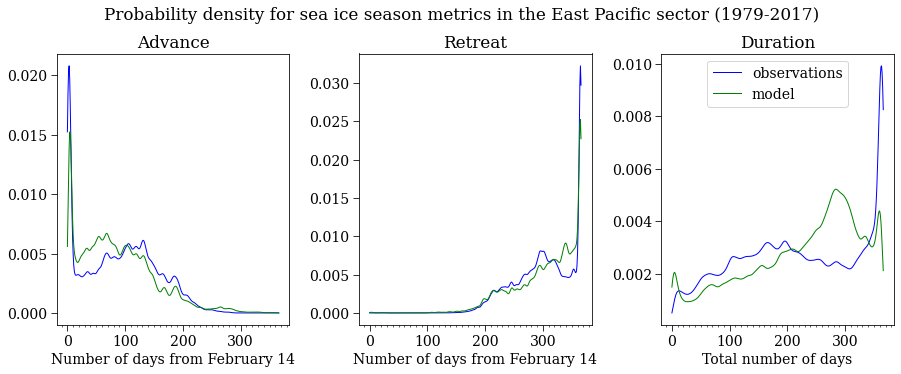

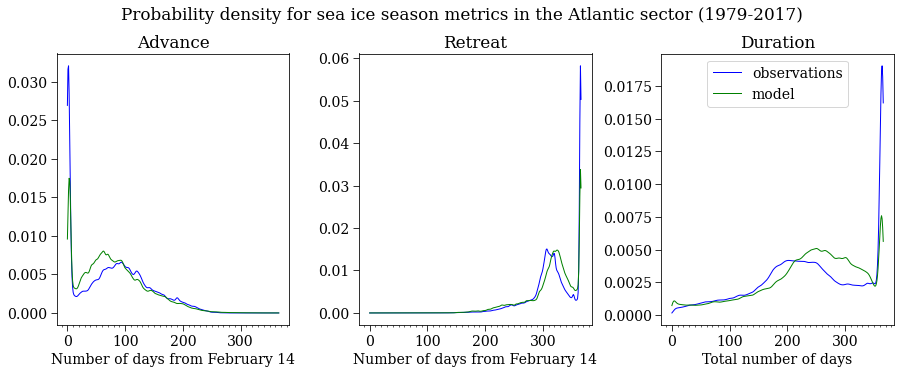

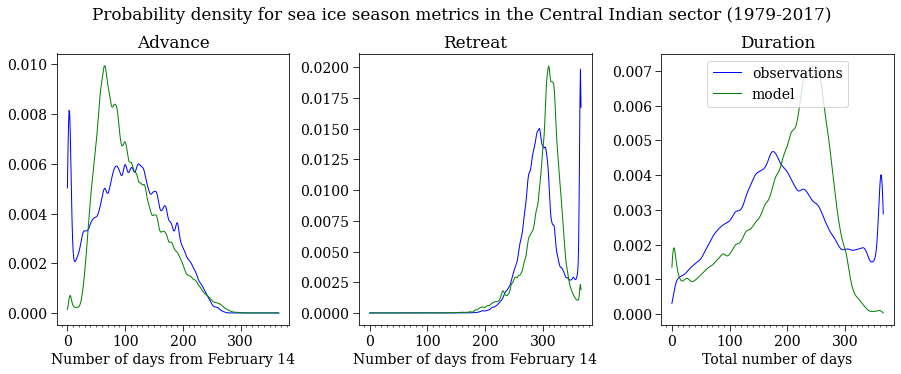

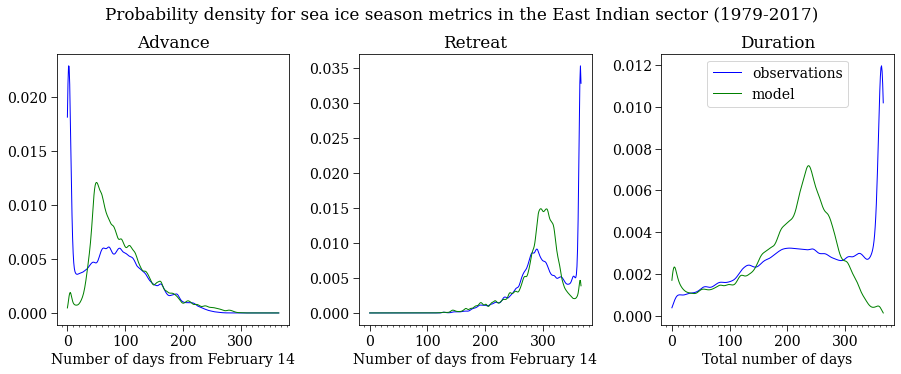

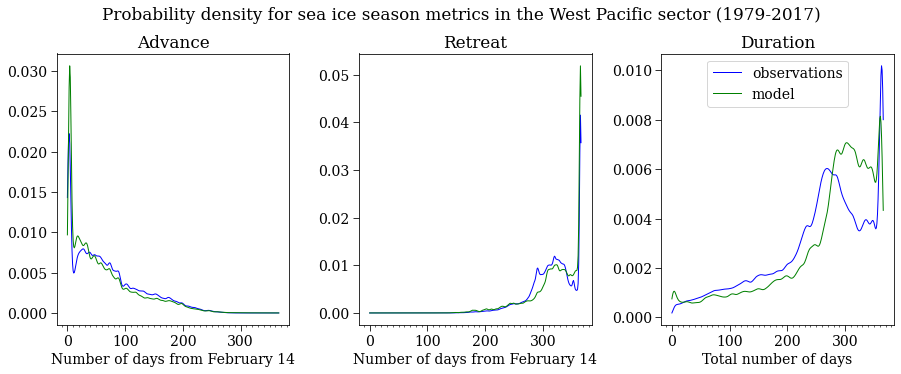

In [7]:
#Folder where figures will be saved
out_folder = r'/g/data/v45/la6889/Figures/PDFs/SIS/Scipy/'
#Apply plotting function
[plot_PDFss(clipped_SIS_obs[sec], clipped_SIS[sec], bins = np.arange(0, 367),
          out_folder = out_folder) for sec in sectorNames]

### Using scikit learn KDE function

In [58]:
def plot_PDFsk(obs, mod, bins, bw, **kwargs):  
    #Initialising figure
    fig = plt.figure(figsize = (15, 5))

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Create a grid inside the figure with seasons defining the number of rows and one column
    gs = gridspec.GridSpec(ncols = len(SI_seasons), nrows = 1)
    gs.update(wspace = 0.3)
    
    for i in range(len(SI_seasons)):
        ax = fig.add_subplot(gs[i])
        #Stacking data and apply
        #Models
        s_mod = mod[SI_seasons[i]].sel(time = slice('1979', '2017')).\
        stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_mod = ~np.isnan(s_mod)
        masked_mod = s_mod[mask_mod]
        #Observations
        s_obs = obs[SI_seasons[i]].sel(time = slice('1979', '2017')).\
        stack(z = ('time', 'xt_ocean', 'yt_ocean'))
        mask_obs = ~np.isnan(s_obs)
        masked_obs = s_obs[mask_obs]
        
        #Calculating KDEs
        #Models
        kde_mod = KernelDensity(bandwidth = bw, kernel = 'gaussian').\
        fit(masked_mod.values[:,np.newaxis])
        pdf_mod = kde_mod.score_samples(bins[:,np.newaxis])
        #Observations
        kde_obs = KernelDensity(bandwidth = bw, kernel = 'gaussian').\
        fit(masked_obs.values[:,np.newaxis])
        pdf_obs = kde_obs.score_samples(bins[:,np.newaxis])
        
        #Plotting data
        ax.plot(bins, np.exp(pdf_obs), color = 'blue', linewidth = 1, 
                label = 'observations', linestyle = 'dashed')     
        ax.plot(bins, np.exp(pdf_mod), color = 'green', label = 'model', 
                linewidth = 1, linestyle = 'dashed')
        ax.set_title(f'{SI_seasons[i].title()}')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included
        #between each major tick pair 
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 10))
        if i < 2:
            ax.set_xlabel('Number of days from February 14')
        else:
            ax.set_xlabel('Total number of days')
            ax.legend(loc = 'upper center')
    
    reg = str(obs.region.values)
    fig.suptitle(f'Probability density for sea ice season metrics in the {reg} sector (1979-2017)',
                y = 1.01)

    #Saving figure
    if 'out_folder' in kwargs.keys():
        #Ensuring folder exists
        os.makedirs(kwargs.get('out_folder'), exist_ok = True)
        plt.savefig(os.path.join(kwargs.get('out_folder'), f'PDFs_{reg}_1979-2017_sk.png'), 
                    dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

In [59]:
#Folder where figures will be saved
out_folder = r'/g/data/v45/la6889/Figures/PDFs/SIS/Scikit/'
#Apply plotting function
[plot_PDFsk(clipped_SIS_obs[sec], clipped_SIS[sec], bins = np.arange(0, 367), bw = 1,
          out_folder = out_folder) for sec in sectorNames]

KeyError: 'East Pacific'